## Basic EDA

### 0.  Load Env Variables

In [1]:
# run this if running locally not requires if you used the docker script
#!pip install python-dotenv
# from dotenv import load_dotenv
# load_dotenv(dotenv_path = '../.env')

### 1. Import requires packages

In [2]:
import pandas as pd
import seaborn as sns

from mlcore.data_helper import load_data
from mlcore.utils import set_logger
from mlcore.feature_extractor import *

In [3]:
eda_logger = set_logger('training')

### 2 .Load Click Data  and extract features
    - join with stores data to get merchant_info
    - extract time based features such which day/hour a click was made
    - extract user based features such as age of user till click etc.

In [4]:
data_dict = {
    'clicks':None,
    'users':None,
    'stores':None
}


for schema_name in data_dict:
    data_dict[schema_name] = load_data(schema_name, logger = eda_logger)

2021-11-21 08:21:03,676:Loaded schema clicks in dataframe with shape (10000, 8)
2021-11-21 08:21:03,682:Loaded schema users in dataframe with shape (500, 3)
2021-11-21 08:21:03,686:Loaded schema stores in dataframe with shape (100, 2)


In [5]:
#data_dict['clicks']
#data_dict['stores']
#data_dict['users']

In [6]:
transformed_data = data_dict['clicks']

In [7]:
transformed_data

,index,id,user_id,store_id,created_at,device,channel,platform
0,1000,7882,125,30,2021-09-26 01:17:41,desktop,direct,extension
1,1001,9658,182,26,2021-08-28 02:02:38,desktop,direct,app
2,1002,6240,379,34,2021-10-02 22:21:14,tablet,some_adv,extension
3,1003,2154,398,33,2021-10-11 20:23:30,mobile,email,web
4,1004,2643,167,87,2021-09-21 00:56:22,tablet,search,app
...,...,...,...,...,...,...,...,...
9995,10995,7847,197,67,2021-11-13 11:47:41,tablet,direct,web
9996,10996,7133,297,28,2021-11-12 09:23:05,desktop,search,extension
9997,10997,9162,118,80,2021-11-11 20:32:33,desktop,some_adv,app
9998,10998,8651,17,70,2021-09-09 05:11:54,tablet,direct,web


In [8]:
# join with stores and extract time features
stores_df = data_dict['stores']
transformed_data = pd.merge(transformed_data, stores_df, left_on = 'store_id', right_on = 'id')
extract_time_features(transformed_data)
transformed_data.iloc[0:1].to_dict()

{'index': {0: 1000},
 'id_x': {0: 7882},
 'user_id': {0: 125},
 'store_id': {0: 30},
 'created_at': {0: Timestamp('2021-09-26 01:17:41')},
 'device': {0: 'desktop'},
 'channel': {0: 'direct'},
 'platform': {0: 'extension'},
 'id_y': {0: 30},
 'merchant_id': {0: 5},
 'hour_of_day': {0: 1},
 'day_of_week': {0: 'Sunday'},
 'month_of_year': {0: 9},
 'date': {0: datetime.date(2021, 9, 26)}}

In [9]:
# join with users

users_df = data_dict['users']
transformed_data = extract_user_features(transformed_data, users_df)
transformed_data.iloc[0].to_dict()

{'index': 1000,
 'id_x': 7882,
 'user_id': 125,
 'store_id': 30,
 'created_at': Timestamp('2021-09-26 01:17:41'),
 'device': 'desktop',
 'channel': 'direct',
 'platform': 'extension',
 'id_y': 30,
 'merchant_id': 5,
 'hour_of_day': 1,
 'day_of_week': 'Sunday',
 'month_of_year': 9,
 'date': datetime.date(2021, 9, 26),
 'id': 125,
 'signup_datetime': '2021-08-25 07:55:34',
 'lifetime_first_purchase_datetime': '2021-09-16 12:06:58',
 'click_delta_signup': 45682.11666666667,
 'click_delta_first_purchase': 13750.716666666667}

In [10]:
#ser_item_preference[user_item_preference.user_id==250442]

### 3. EDA

### 3.1 Click click distributon by time

In [11]:
def snsplot_new_version(snsplot):
    snsplot.fig.subplots_adjust(top=0.9)
    for ax in snsplot.axes.ravel():
        for c in ax.containers:
            labels = [f'{(v.get_height()):.3f}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        ax.margins(y=0.3)
    return snsplot


def snsplot(snsplot, title):
    
    snsplot.fig.subplots_adjust(top=0.9)

    ax = snsplot.facet_axis(0,0)
    for p in ax.patches:
        ax.text(p.get_x(),# - 0.01 , 
                p.get_height() * 1.02, 
               '{0:.2f}'.format(p.get_height()),   
                color='black', 
                rotation='horizontal', 
                size='large')
    ax.set_title(title)

def snsplot_y(snsplot,title):
    snsplot.fig.subplots_adjust(top=0.9)
    
    ax = snsplot.facet_axis(0,0)
    prevy = 0
    for p in ax.patches:
        
        x = p.get_x()
        y = p.get_y()
        val = p.get_width()
        #print(x, y, y-prevy)
        ax.text(
            (x+val)*1.05,
             y +0.5,
             #y *1.5,
            '{0:.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='large')
        prevy = y
    ax.set_title(title)

In [12]:
day_hour_month = transformed_data.groupby(['hour_of_day','day_of_week','month_of_year', 'date']).size().reset_index(name='clicks')
day_hour_month_avg = day_hour_month.groupby(['hour_of_day','day_of_week'])['clicks'].mean().reset_index(name='avg_clicks')
day_hour_month

,hour_of_day,day_of_week,month_of_year,date,clicks
0,0,Friday,8,2021-08-27,8
1,0,Friday,9,2021-09-03,4
2,0,Friday,9,2021-09-10,4
3,0,Friday,9,2021-09-17,2
4,0,Friday,9,2021-09-24,6
...,...,...,...,...,...
2113,23,Wednesday,10,2021-10-20,7
2114,23,Wednesday,10,2021-10-27,6
2115,23,Wednesday,11,2021-11-03,4
2116,23,Wednesday,11,2021-11-10,7


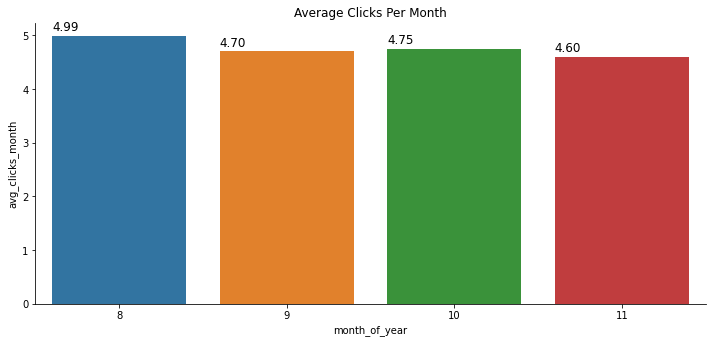

In [13]:
avg_clicks_per_month = day_hour_month.groupby('month_of_year')['clicks'].mean().reset_index(name='avg_clicks_month')
snsplot(
    sns.catplot(
        y='avg_clicks_month', 
        x='month_of_year',
        data =avg_clicks_per_month,
        kind = 'bar',
        height=5, 
        aspect=2,
      
    ),
       "Average Clicks Per Month")


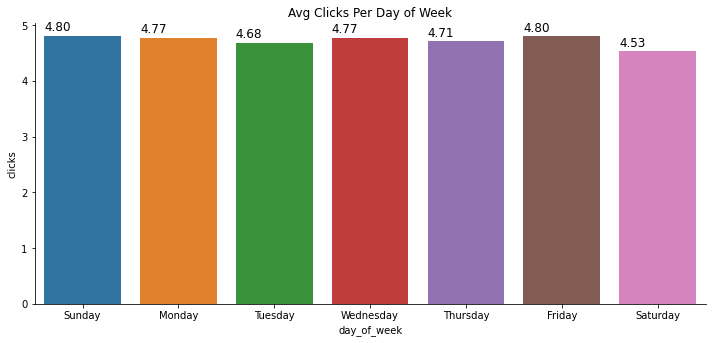

In [14]:
snsplot(sns.catplot(
    y="clicks", 
    x = "day_of_week", 
    data=day_hour_month,
    kind='bar',
    height=5, 
    aspect=2,
    order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
    ci=None
),
       
       "Avg Clicks Per Day of Week")



In [15]:
#day_hour_month[day_hour_month.day_of_week=='Friday'].clicks.mean()
#transformed_data[transformed_data.day_of_week=='Friday'].shape

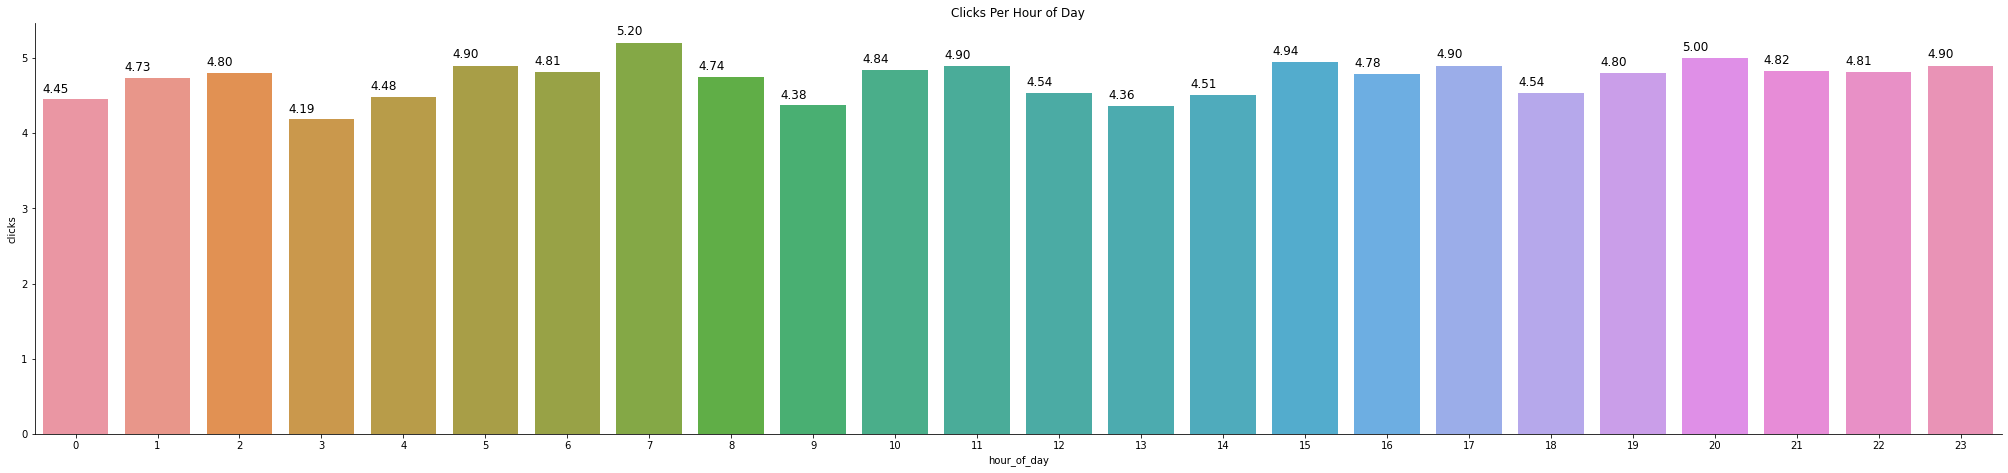

In [16]:
snsplot(sns.catplot(y="clicks", 
            x = "hour_of_day", 
            data=day_hour_month,
            kind='bar',
            height=7, 
            aspect=4,
            ci=None),
        
       "Clicks Per Hour of Day"
       )

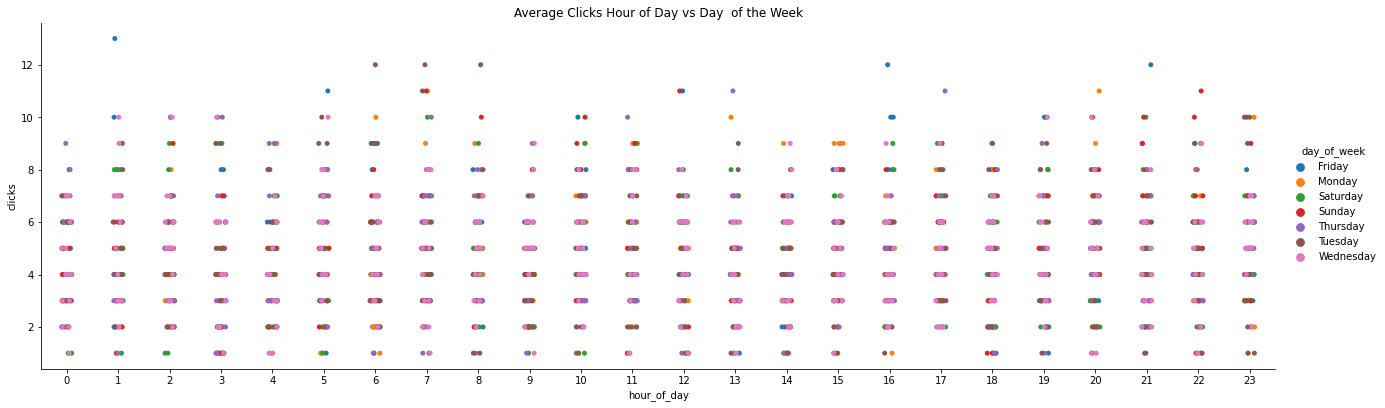

In [17]:
p = sns.catplot(y="clicks", 
            x = "hour_of_day", 
            data=day_hour_month,
            kind='strip',
            hue='day_of_week',
            height=6, 
            aspect=3)
p.fig.subplots_adjust(top=0.9)
ax = p.facet_axis(0,0)
_= ax.set_title("Average Clicks Hour of Day vs Day  of the Week")

#### 3.2 Click click distributon by Channel/Source

In [18]:
#transformed_data.iloc[0].to_dict()

In [19]:
plat_chan_dev = transformed_data.groupby(['platform','channel','device', 'day_of_week','date']).size().reset_index(name='clicks')
plat_chan_dev_avg = plat_chan_dev.groupby(['platform','channel','device', 'day_of_week','date'])['clicks'].mean().reset_index(name='avg_clicks')
plat_chan_dev

,platform,channel,device,day_of_week,date,clicks
0,app,direct,desktop,Friday,2021-09-03,2
1,app,direct,desktop,Friday,2021-09-17,2
2,app,direct,desktop,Friday,2021-09-24,1
3,app,direct,desktop,Friday,2021-10-01,2
4,app,direct,desktop,Friday,2021-10-08,2
...,...,...,...,...,...,...
3075,web,some_adv,tablet,Wednesday,2021-10-20,1
3076,web,some_adv,tablet,Wednesday,2021-10-27,3
3077,web,some_adv,tablet,Wednesday,2021-11-03,2
3078,web,some_adv,tablet,Wednesday,2021-11-10,2


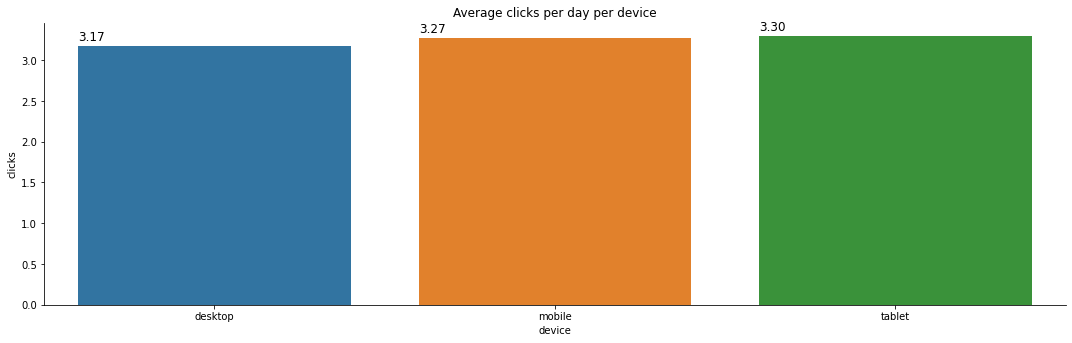

In [20]:
snsplot(
    sns.catplot(
        y='clicks', 
        x='device',
        data =plat_chan_dev,
        kind = 'bar',
        height=5, 
        aspect=3,
        ci = None
      
    ),
      "Average clicks per day per device" )


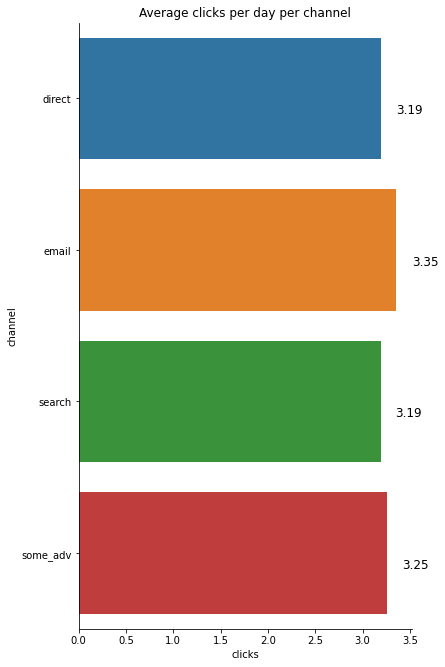

In [21]:
snsplot_y(
    sns.catplot(
        x='clicks', 
        y='channel',
        data =plat_chan_dev,
        kind = 'bar',
        height=10, 
        aspect=0.6,
        ci = None
      
    ),
      "Average clicks per day per channel" )


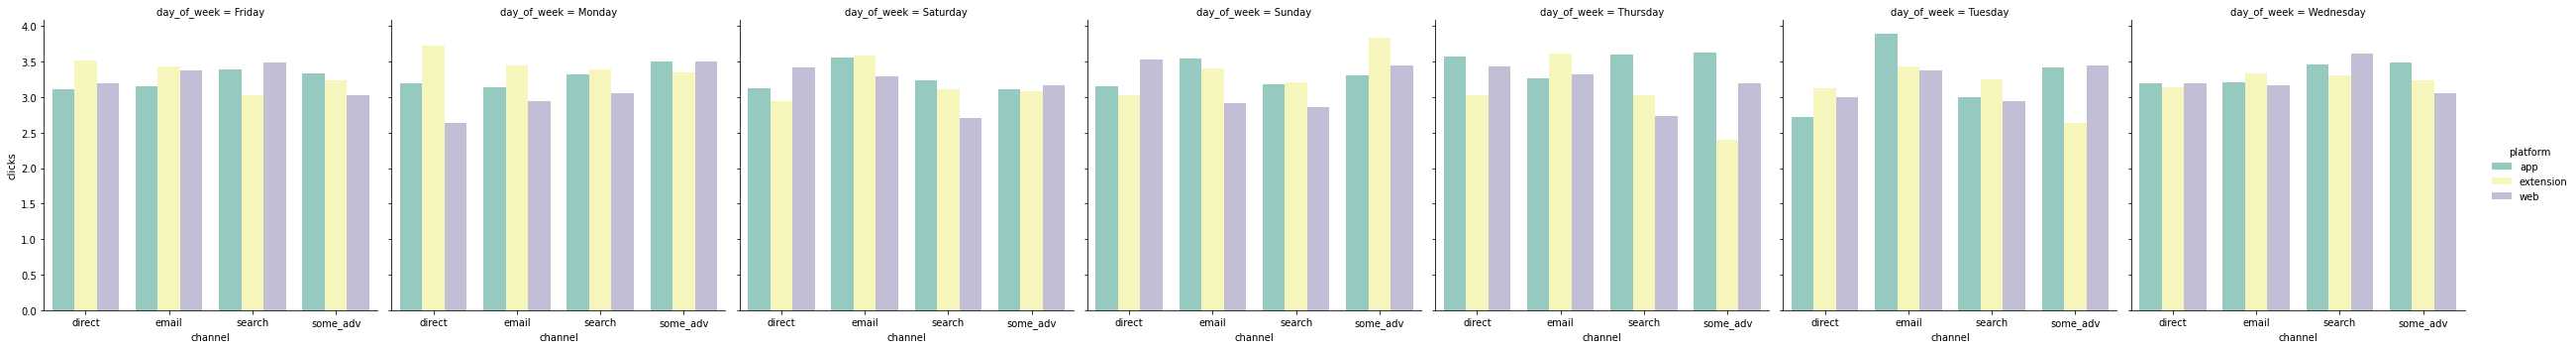

In [22]:
# Click Traffic for Top 3 Chanels per platform and per day of week

top_channels = plat_chan_dev[plat_chan_dev.channel.apply(lambda x : x in 
                                                         ['direct', 'email', 'search', 'some_adv'])]

p2=sns.catplot(
    x='channel', 
    hue='platform',
    data =top_channels,
    kind = 'bar',
    y = 'clicks',
    col = 'day_of_week',
    #orient="h", 
    height=5, 
    aspect=1, 
    palette="Set3",
    dodge=True, 
    ci = None
)
# p2.fig.subplots_adjust(top=0.9)
# ax2 = p2.facet_axis(0,0)
# _ = ax2.set_title("Click Traffic for Top 3 Chanels per platform and per day of week")

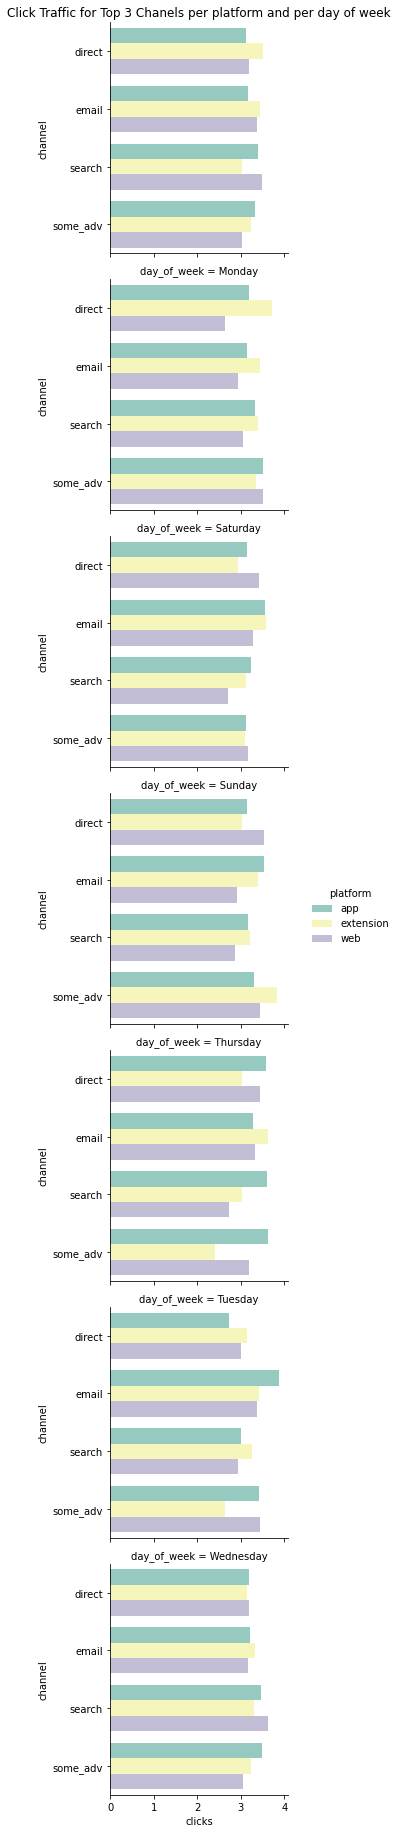

In [23]:
# Click Traffic for Top 3 Chanels per platform and per day of week

top_channels = plat_chan_dev[plat_chan_dev.channel.apply(lambda x : x in 
                                                         ['direct', 'email', 'search', 'some_adv'])]

p2=sns.catplot(
    y='channel', 
    hue='platform',
    data =top_channels,
    kind = 'bar',
    x = 'clicks',
    row = 'day_of_week',
    orient="h", 
    height=4, 
    aspect=1, 
    palette="Set3",
    dodge=True, 
    ci = None
)
p2.fig.subplots_adjust(top=0.9)
ax2 = p2.facet_axis(0,0)
_ = ax2.set_title("Click Traffic for Top 3 Chanels per platform and per day of week")